# Daily Mail Text Summarization using Transformers

## 1. Dataset Loading & Inspection

### 1.1 Load the CSV File

In [1]:
import pandas as pd

DATA_PATH = "/kaggle/input/daily-mail-summarization-dataset/article_highlights.csv"

df = pd.read_csv(DATA_PATH)

### 1.2 Inspect the Dataset

In [2]:
df.head()

,url,article,highlights
0,https://www.dailymail.co.uk/tvshowbiz/article-...,Beyoncé showcases her incredible figure in plu...,Beyoncé has shown off her flawless beauty in a...
1,https://www.dailymail.co.uk/tvshowbiz/article-...,Radio 1 listeners in shock as sex noises are p...,BBC Radio 1 listeners were left choking on the...
2,https://www.dailymail.co.uk/tvshowbiz/article-...,"TOWIE's Dan Edgar, 33, and Ella Rae Wise, 23, ...",Dan Edgar and Ella Rae Wise put on a loved-up ...
3,https://www.dailymail.co.uk/tvshowbiz/article-...,Bradley Cooper recalls 'crazy' pitch meeting a...,Bradley Cooper discussed the 'crazy' experienc...
4,https://www.dailymail.co.uk/tvshowbiz/article-...,Margaret Qualley and Beanie Feldstein stun in ...,Margaret Qualley and Beanie Feldstein were dre...


In [3]:
print("Total samples:", len(df))
df.isnull().sum()

Total samples: 8176


url            0
article       11
highlights     3
dtype: int64

### 1.3 Drop Invalid Rows

In [4]:
df = df.dropna(subset=["article", "highlights"])
df = df.reset_index(drop=True)

print("Samples after cleaning:", len(df))

Samples after cleaning: 8165


### 1.4 Inspect Text Lengths

In [5]:
df["article_length"] = df["article"].apply(lambda x: len(str(x).split()))
df["summary_length"] = df["highlights"].apply(lambda x: len(str(x).split()))

df[["article_length", "summary_length"]].describe()

,article_length,summary_length
count,8165.000000,8165.000000
mean,44.832456,23.055726
std,10.618829,9.135632
min,28.000000,5.000000
25%,37.000000,18.000000
50%,44.000000,22.000000
75%,51.000000,28.000000
max,78.000000,53.000000


## 2. Minimal Text Cleaning & Preparation

### 2.1 Select Only Required Columns

In [6]:
df = df[["article", "highlights"]]

### 2.2 Basic Text Normalization

In [7]:
import re

def clean_text(text):
    text = str(text)
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

df["article"] = df["article"].apply(clean_text)
df["highlights"] = df["highlights"].apply(clean_text)

df.head()

,article,highlights
0,Beyoncé showcases her incredible figure in plu...,Beyoncé has shown off her flawless beauty in a...
1,Radio 1 listeners in shock as sex noises are p...,BBC Radio 1 listeners were left choking on the...
2,"TOWIE's Dan Edgar, 33, and Ella Rae Wise, 23, ...",Dan Edgar and Ella Rae Wise put on a loved-up ...
3,Bradley Cooper recalls 'crazy' pitch meeting a...,Bradley Cooper discussed the 'crazy' experienc...
4,Margaret Qualley and Beanie Feldstein stun in ...,Margaret Qualley and Beanie Feldstein were dre...


## 3. Convert to Hugging Face Dataset & Split

### 3.1 Convert Pandas DataFrame ti Hugging Face Dataset

In [8]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['article', 'highlights'],
    num_rows: 8165
})

### 3.2 Create Train / Validation Split

In [9]:
from datasets import Dataset, DatasetDict

dataset = dataset.shuffle(seed=42)

val_dataset = dataset.select(range(100))
train_dataset = dataset.select(range(100, len(dataset)))

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})


## 4. Load Tokenizer & Tokenize the Dataset

### 4.1 Load the Tokenizer

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

### 4.2 Tokenization Function

In [11]:
MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 64


def tokenize_function(batch):
    model_inputs = tokenizer(
        batch["article"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["highlights"],
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            padding="max_length"
        )

    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


### 4.3 Apply Tokenization to the Dataset

In [12]:
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["article", "highlights"]
)

tokenized_datasets["train"][0].keys()

Map:   0%|          | 0/8065 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])

## 5. Load the Model & Prepare the Data Collator


### 5.1 Load the Pretrained Model

In [13]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

model.config.max_length = 64
model.config.min_length = 20
model.config.num_beams = 4
model.config.length_penalty = 2.0

2025-12-24 08:24:52.243082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766564692.418092      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766564692.467337      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766564692.895588      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766564692.895633      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766564692.895636      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

### 5.2 Move Model to GPU

In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


### 5.3 Create Data Collator

In [15]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model
)

## 6. Define Training Arguments

In [16]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_summarizer",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    fp16=True,
    logging_steps=500,
    logging_dir="./logs",
    save_steps=1000000,  
    do_train=True,
    do_eval=True,
    report_to="none"
)


## 7. ROUGE Metric & Trainer Setup


### 7.1 ROUGE Metric


In [17]:
!pip install rouge-score -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done


In [18]:
from rouge_score import rouge_scorer
import torch
import numpy as np

def compute_metrics(pred):
     
    pred_ids = pred.predictions
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]

    if isinstance(pred_ids, np.ndarray):
        if pred_ids.ndim == 3:   
            pred_ids = np.argmax(pred_ids, axis=-1).tolist()
        else:
            pred_ids = pred_ids.tolist()
    elif torch.is_tensor(pred_ids):
        if pred_ids.ndim == 3:
            pred_ids = torch.argmax(pred_ids, dim=-1).detach().cpu().tolist()
        else:
            pred_ids = pred_ids.detach().cpu().tolist()
 
    pred_str = [tokenizer.decode(ids, skip_special_tokens=True) for ids in pred_ids]
 
    labels_ids = pred.label_ids
    if torch.is_tensor(labels_ids):
        labels_ids = labels_ids.detach().cpu().tolist()
    elif isinstance(labels_ids, np.ndarray):
        labels_ids = labels_ids.tolist()
 
    label_str = []
    for ids in labels_ids:
        ids = [tokenizer.pad_token_id if i == -100 else i for i in ids]
        label_str.append(tokenizer.decode(ids, skip_special_tokens=True))
 
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = 0, 0, 0
    n = len(pred_str)
    for ref, hyp in zip(label_str, pred_str):
        scores = scorer.score(ref, hyp)
        rouge1 += scores['rouge1'].fmeasure
        rouge2 += scores['rouge2'].fmeasure
        rougeL += scores['rougeL'].fmeasure

    return {
        'rouge1': round(rouge1/n, 4),
        'rouge2': round(rouge2/n, 4),
        'rougeL': round(rougeL/n, 4)
    }


### 7.2 Initialize the Trainer

In [19]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_55/87520850.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


## 8. Model Training

### 8.1 Define a Helper Function for Evaluation & Saving Best Model

In [20]:
import os
import torch
import shutil

def train_and_save_best(trainer, output_dir="./best_bart_summarizer", num_total_epochs=4):
    train_losses = []
    val_rougeL = []
    epoch_dirs = []

    trainer.args.num_train_epochs = 1   

    for epoch in range(num_total_epochs):
        print(f"\n===== Epoch {epoch+1} / {num_total_epochs} =====")

        trainer.train(resume_from_checkpoint=False)
 
        train_step_logs = [log for log in trainer.state.log_history if "loss" in log and "epoch" in log]
        if train_step_logs:
            avg_loss = sum(log["loss"] for log in train_step_logs) / len(train_step_logs)
        else:
            avg_loss = 0.0
        train_losses.append(avg_loss)
  

        torch.cuda.empty_cache()
        metrics = trainer.evaluate()
        rougeL = metrics.get("eval_rougeL", 0)
        val_rougeL.append(rougeL)

        print(f"Average Training Loss: {avg_loss:.4f}, Validation ROUGE-L: {rougeL:.4f}")
 
        epoch_dir = os.path.join(output_dir, f"epoch_{epoch+1}")
        os.makedirs(epoch_dir, exist_ok=True)
        trainer.model.save_pretrained(epoch_dir)
        trainer.tokenizer.save_pretrained(epoch_dir)
        epoch_dirs.append(epoch_dir)
 
    best_epoch_idx = val_rougeL.index(max(val_rougeL))
    best_epoch_dir = epoch_dirs[best_epoch_idx]

    final_output_dir = os.path.join(output_dir, "best_model")
    if os.path.exists(final_output_dir):
        shutil.rmtree(final_output_dir)
    shutil.copytree(best_epoch_dir, final_output_dir)

    print(f"\nTraining complete. Best epoch: {best_epoch_idx+1} with ROUGE-L: {val_rougeL[best_epoch_idx]:.4f}")
    print(f"Best model saved to {final_output_dir}")

    return train_losses, val_rougeL


### 8.2 Training the model


In [21]:
train_losses, val_rougeL = train_and_save_best(trainer)


===== Epoch 1 / 4 =====


Step,Training Loss
500,0.025100


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'min_length': 20, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Average Training Loss: 0.0251, Validation ROUGE-L: 0.8681


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



===== Epoch 2 / 4 =====


Step,Training Loss
500,0.004400


Average Training Loss: 0.0044, Validation ROUGE-L: 0.7702


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



===== Epoch 3 / 4 =====


Step,Training Loss
500,0.002100


Average Training Loss: 0.0021, Validation ROUGE-L: 0.8457


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



===== Epoch 4 / 4 =====


Step,Training Loss
500,0.001300


Average Training Loss: 0.0013, Validation ROUGE-L: 0.7055


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Training complete. Best epoch: 1 with ROUGE-L: 0.8681
Best model saved to ./best_bart_summarizer/best_model


### 8.3 Plotting

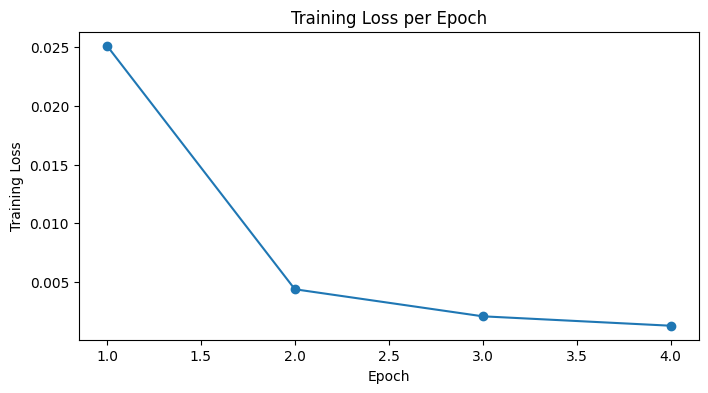

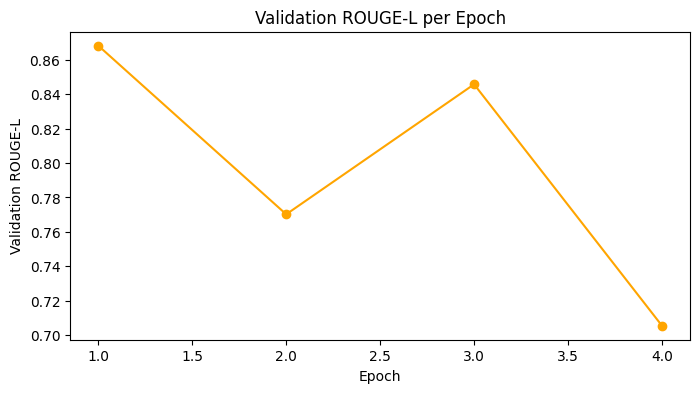

In [23]:
import matplotlib.pyplot as plt
import os

plot_dir = "./plots"
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
loss_plot_path = os.path.join(plot_dir, "training_loss.png")
plt.savefig(loss_plot_path)
plt.show()
plt.close()

plt.figure(figsize=(8,4))
plt.plot(range(1, len(val_rougeL)+1), val_rougeL, marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Validation ROUGE-L")
plt.title("Validation ROUGE-L per Epoch")
rouge_plot_path = os.path.join(plot_dir, "validation_rougeL.png")
plt.savefig(rouge_plot_path)
plt.show()
plt.close()
